In [146]:
#!pip install qiskit==0.44.3
#!pip install qiskit-aer==0.13.0


**Task 2: Odd to Even**

Design a quantum algorithm that when given numbers of range [1,n) and are odd convert them into even numbers, and they must stay in the same range so they cannot be less than 1 nor greater than n. n = 2^k where k is the number of qubits you are going to use.


The algorithm to solving the task 2 is to perform the following operations
- create a quantum instruction/operator (called as Evener) that converts an odd binary integer to even integer (and no-op if input is already even)
- loop through the input list, 
   - encode the current integer to binary representation and pass it through the Evener operator.
   - decode the integer and append it to the final answer.
- We need log2(n) + k qubits
- Time Complexity is O(n) as we go through each element to check if it is odd or even.

In [147]:
from qiskit import *
from qiskit_aer import AerSimulator
import math

**Create the circuit that checks for even or odd.**

- We create instructions for our circuit here which takes any binary integer and converts it to a nearest even number
- This circuit takes n+2 qubits where n is minimum number of qubits required to represent the integer and 2 ancilla bits
  - The first ancilla is used to find if the input integer is "1". If the input integer is 1 we want to convert it to "2" (nearest even number greater than 1)
  - The second ancilla is used to find if the input integer is odd. if it is odd, we want to flip the least significant bit to make it even, This is essentially a -1 operation. without the need of the substractor circuit. uses lesser gate depth.

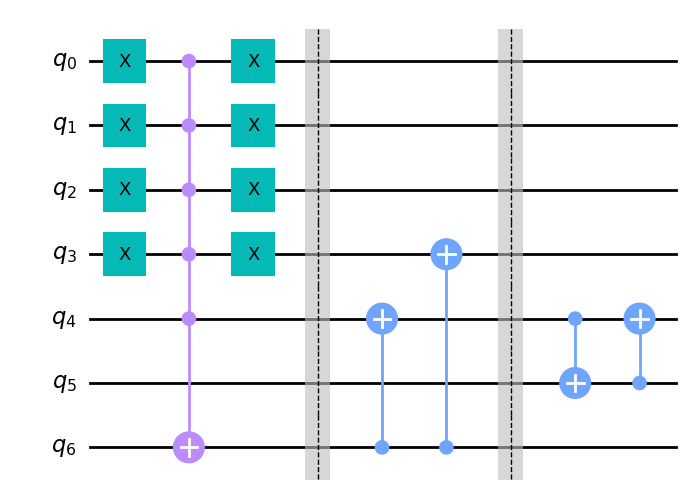

In [148]:
def Evener(n: int) -> QuantumCircuit:
   circuit = QuantumCircuit(n+2)
   # identify if the input is 1
   circuit.x(range(0,n-1))
   # mark the ancilla if input is 1
   circuit.mcx(list(range(0,n)), [n+1])
   circuit.x(range(0,n-1))

   circuit.barrier()
   # set 1 to 2 if the input is 1
   circuit.mcx([n+1], [n-1, n-2])
   circuit.barrier()
   # if the input is not 1 then the flip the LSB if it is odd
   circuit.mcx([n-1], [n])
   circuit.mcx([n], [n-1])
   return circuit

# sample Evener circuit for 5 bits (7 qubits)
Evener(5).draw("mpl")

The next section of the code creates a few helper functions
- binary - converts the integer to fixed (n) size binary string
- integer - converts the binary string to integer
- check - applies the "Evener" on the binary string

In [149]:
def binary(a: int, n: int) -> str:
   """ converts an integer to binary. """
   return format(a, '0>'+str(n)+'b')

def integer(l: str) -> int:
   """ converts a binary string to corresponding decimal integer. """
   result = 0
   for digits in l:
      result = (result << 1) | int(digits)
   return result

def check(circuit: QuantumCircuit, binv: str) -> QuantumCircuit:
   """ takes a binary string and and runs it through Evener"""
   n = len(binv)
   operator = Evener(n).to_instruction(label= "Evener " +str(binv))

   circuit.reset(range(n+2))
   for i in range(n):
      if binv[i] == "1":
         circuit.x(i)
   circuit.append(operator, range(n+2))
   return circuit

** odd_to_even **
This section of the code implements the entry point to this algorithm.
- loops through the list and calls check on the binary representation of each of list members
- measures intermediate results (for each integer) and cascades the circuit to ensure we have full circuit for the entire odd_to_even operation

In [150]:
def odd_to_even (n:int, list_n:list):
   n_bits = int(math.ceil(math.log2(n)))
   final_answer = []
   simulator = AerSimulator()
   circuit = QuantumCircuit(n_bits+2, n_bits)
   for v in list_n:
      binv = binary(v, n_bits)
      circuit = check(circuit, binv)
      circuit.measure(range(len(binv)), range(len(binv)))
      circuit.barrier()
      sim = transpile(circuit, simulator)
      result = Aer.get_backend('qasm_simulator').run(sim, shots=1).result()
      final_answer.append(integer(list(result.get_counts())[0][::-1]))
   return final_answer, circuit

The final circuit for a test input [1,2,3,4,9, 15, 17]
The circuit cascades the following sequence
- ```Input binary string -> Evener -> measure -> Reset ```

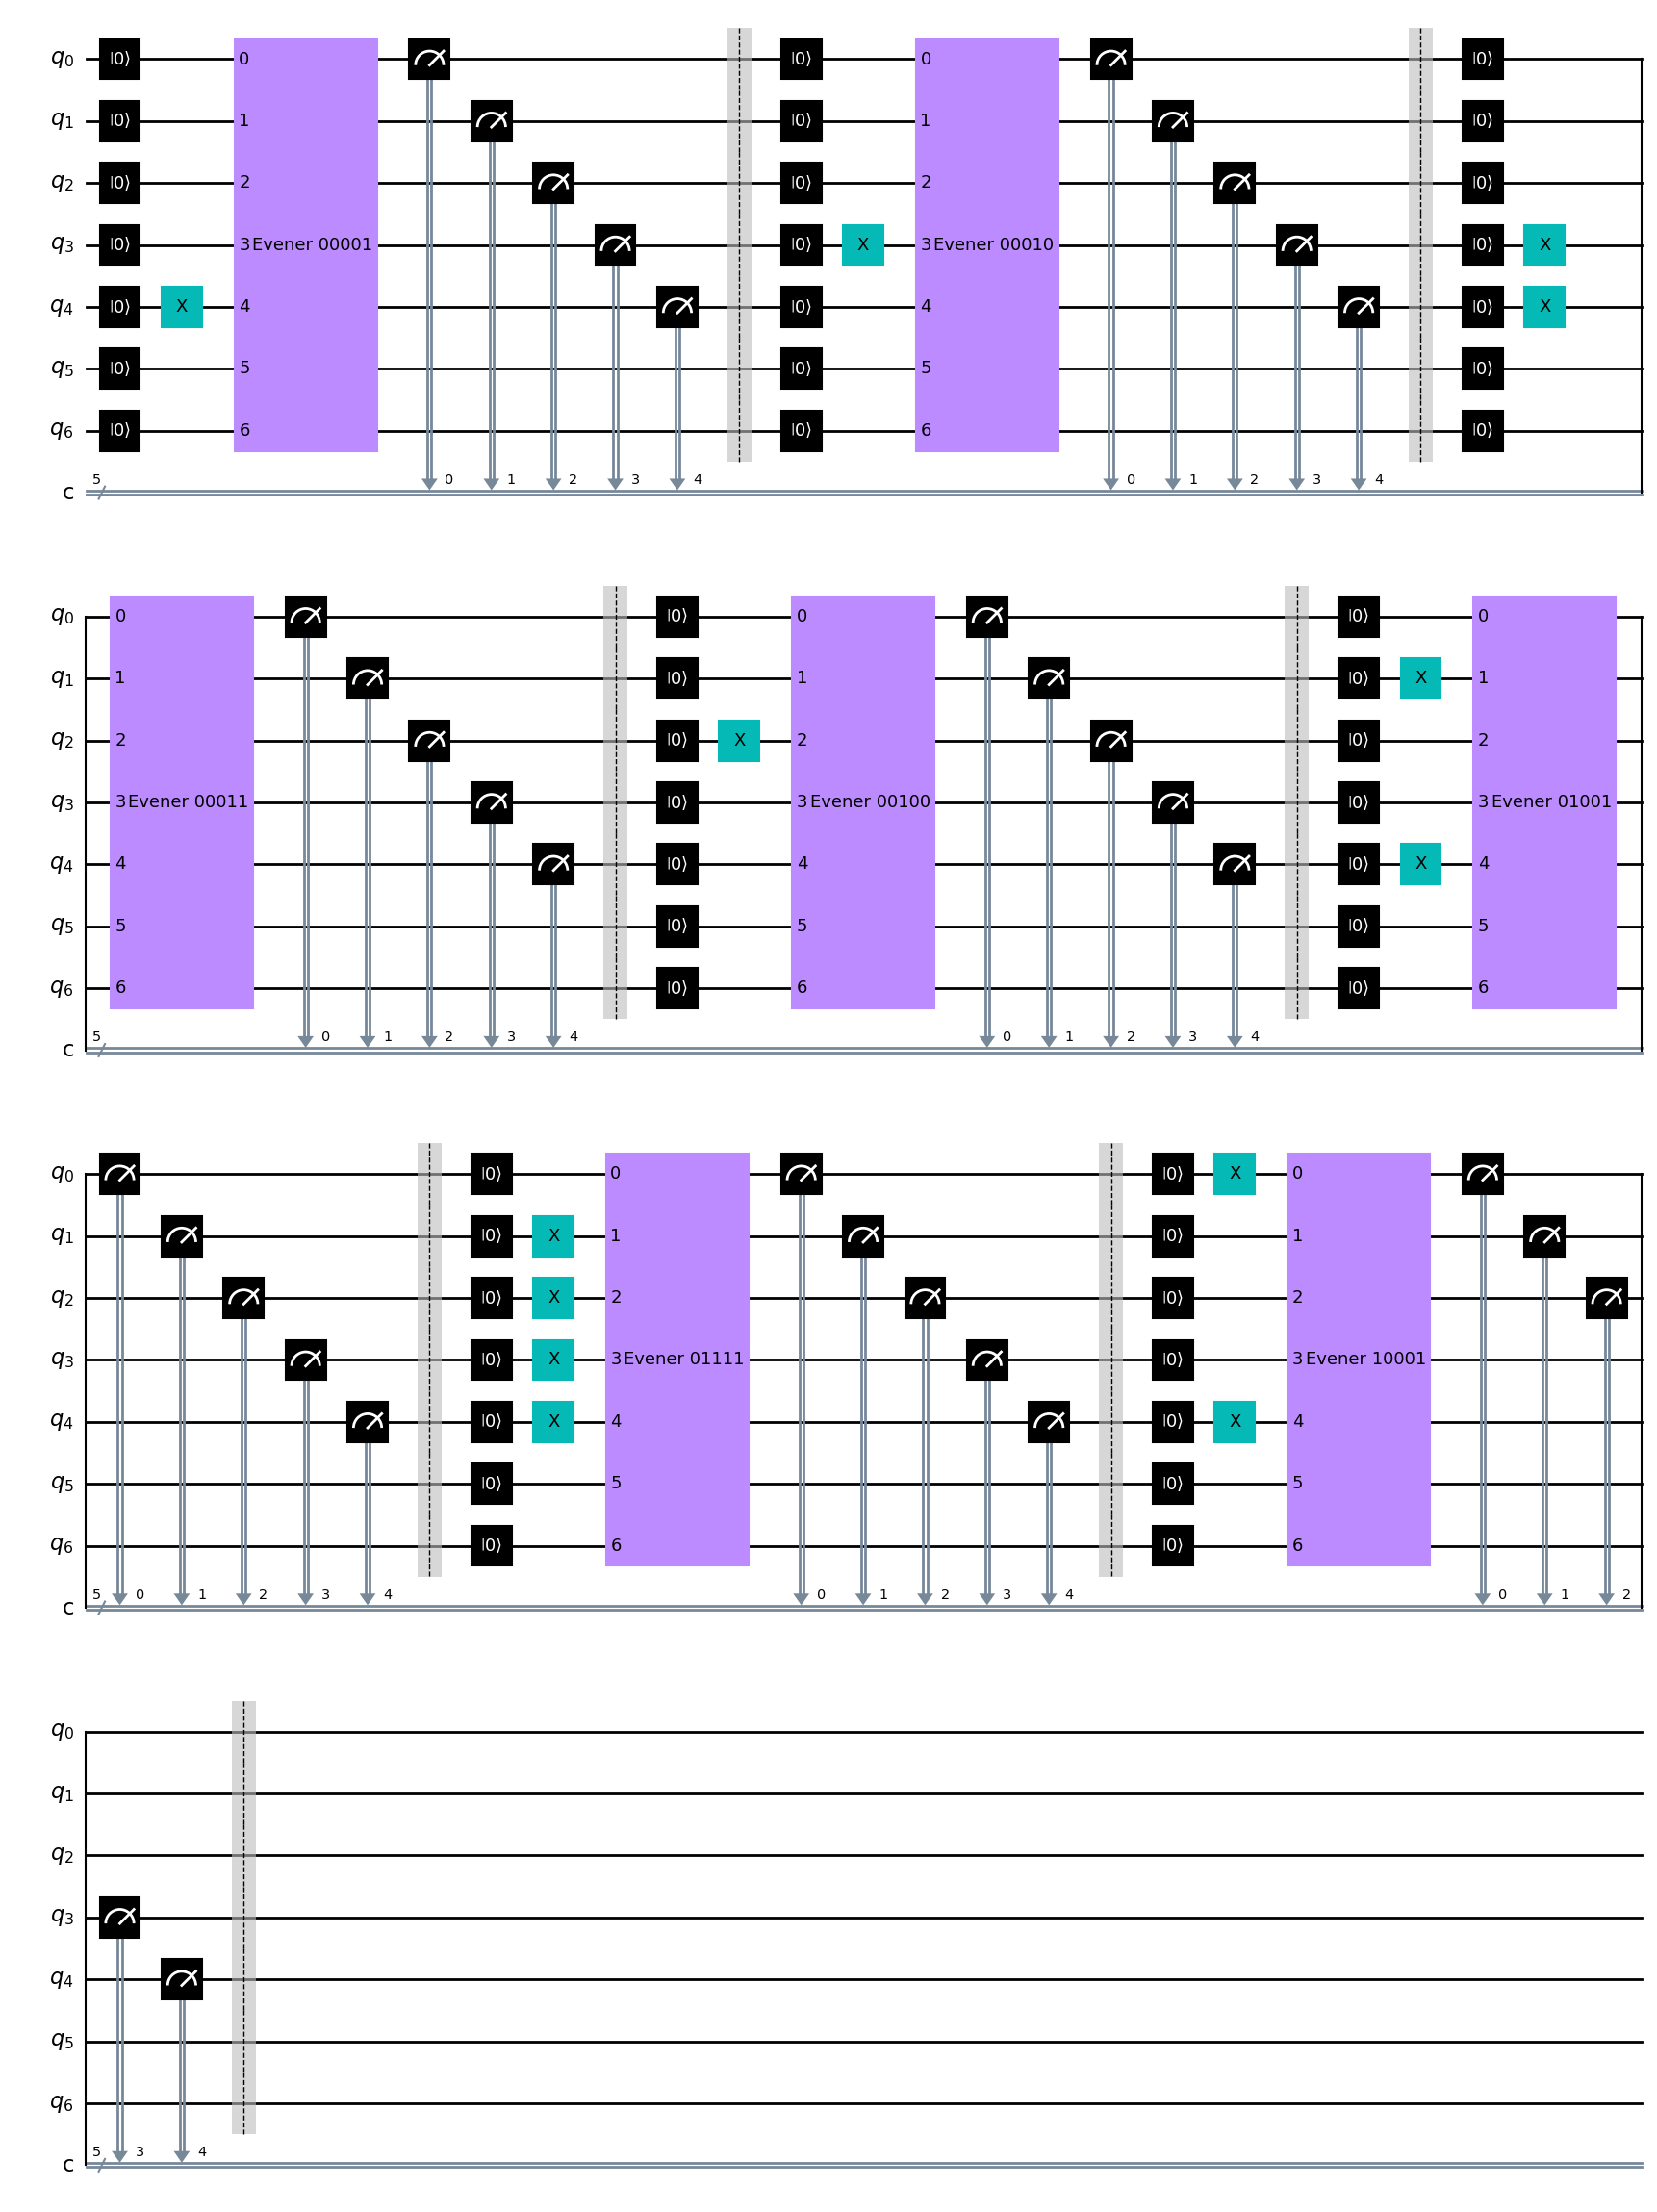

In [151]:
Test_OUTPUT, circuit = odd_to_even(31, list_n= [1,2,3,4,9, 15, 17])
circuit.draw("mpl")

The sample output for the input [1,2,3,4,9, 15, 17]
index 0,2,4,5,6 have been flipped.

In [152]:
print(Test_OUTPUT)

[2, 2, 2, 4, 8, 14, 16]
